In [13]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import stim
print(stim.__version__)

import matplotlib.pyplot as plt
import numpy as np
import math

from ldpc import BpDecoder, BpOsdDecoder
import time
from src.build_SHYPS_circuit import build_SHYPS_circuit
from src.build_circuit import dem_to_check_matrices
from src.codes_q import create_bivariate_bicycle_codes 
from src.utils import edge_coloring_bipartite

1.15.0


In [14]:
decoding_time = []
def decode_SHYPS(r, p, num_repeat, num_shots=10000, max_iter=1000, osd_order=10, window=False, W=3, F=1, plot=False):
    circuit = build_SHYPS_circuit(r, p, num_repeat)
    dem = circuit.detector_error_model()
    # print(dem)
    chk, obs, priors, col_dict = dem_to_check_matrices(dem, return_col_dict=True)
    chk_row_wt = np.sum(chk, axis=1)
    chk_col_wt = np.sum(chk, axis=0)
    num_row, num_col = chk.shape
    print(f"check matrix shape {chk.shape}, max (row, column) weight ({np.max(chk_row_wt)}, {np.max(chk_col_wt)}),",
        f"min (row, column) weight ({np.min(chk_row_wt)}, {np.min(chk_col_wt)})")

    start_time = time.perf_counter()
    dem_sampler: stim.CompiledDemSampler = dem.compile_sampler()
    det_data, obs_data, err_data = dem_sampler.sample(shots=num_shots, return_errors=False, bit_packed=False)
    print("detector data shape", det_data.shape)
    print("observable data shape", obs_data.shape)
    end_time = time.perf_counter()
    print(f"Stim: noise sampling for {num_shots} shots, elapsed time:", end_time-start_time)
    num_err = 0
    num_flag_err = 0
    if not window: # global decoding
        bpd = BpOsdDecoder(
            chk,
            channel_probs=list(priors),
            max_iter=max_iter,
            bp_method="minimum_sum",
            ms_scaling_factor=1.0, # dynamic scaling factor is not in the interface
            osd_method="OSD_CS",
            osd_order=osd_order,
        )
        start_time = time.perf_counter()
        for i in range(num_shots):
            e_hat = bpd.decode(det_data[i])
            num_flag_err += ((chk @ e_hat + det_data[i]) % 2).any()
            ans = (obs @ e_hat + obs_data[i]) % 2
            num_err += ans.any()
        end_time = time.perf_counter()
        if plot:
            plt.imshow(chk.toarray(), cmap="gist_yarg")

    else: # (W,F) sliding window decoding
        ####################### reshuffle columns to show the spatially-coupled structure ####################
        num_det = r * (2**r-1) # number of detectors
        lower_bounds = []
        upper_bounds = []
        i = 0
        while i < num_row:
            lower_bounds.append(i)
            upper_bounds.append(i+num_det)
            if i+num_det > num_row:
                break
            lower_bounds.append(i)
            upper_bounds.append(i+2*num_det)
            i += num_det
            
        region_dict = {}
        for i, (l,u) in enumerate(zip(lower_bounds, upper_bounds)):
            region_dict[(l,u)] = i

        region_cols = [[] for _ in range(len(region_dict))]

        for i in range(num_col):
            nnz_col = np.nonzero(chk[:,i])[0]
            l = nnz_col.min() // num_det * num_det
            u = (nnz_col.max() // num_det + 1) * num_det
            region_cols[region_dict[(l,u)]].append(i)  

        chk = np.concatenate([chk[:,col].toarray() for col in region_cols], axis=1)
        obs = np.concatenate([obs[:,col].toarray() for col in region_cols], axis=1)
        priors = np.concatenate([priors[col] for col in region_cols])
        ############# end of reshuffle, extract window PCMs ##################################################
        anchors = []
        j = 0
        for i in range(num_col):
            nnz_col = np.nonzero(chk[:,i])[0]
            if (nnz_col.min() >= j):
                anchors.append((j, i))
                j += num_det
        anchors.append((num_row, num_col))

        num_win = math.ceil((len(anchors)-W+F-1) / F)
        chk_submats = []
        prior_subvecs = []
        if plot:
            fig, ax = plt.subplots(num_win, 1)
        top_left = 0

        for i in range(num_win):
            a = anchors[top_left]
            bottom_right = min(top_left + W, len(anchors)-1)
            b = anchors[bottom_right]
            mat = chk[a[0]:b[0],a[1]:b[1]]
            prior = priors[a[1]:b[1]]
            chk_submats.append(mat)
            prior_subvecs.append(prior)
            if plot:
                ax[i].imshow(mat, cmap="gist_yarg")
            top_left += F
        ################# decode each window #################################################################
        total_e_hat = np.zeros((num_shots,num_col))
        new_det_data = det_data.copy()
        start_time = time.perf_counter()
        top_left = 0
        for i in range(num_win):
            mat = chk_submats[i]
            prior = prior_subvecs[i]
            a = anchors[top_left]
            bottom_right = min(top_left + W, len(anchors)-1)
            b = anchors[bottom_right]
            c = anchors[top_left+F] # commit region bottom right

            bpd = BpOsdDecoder(
                mat,
                channel_probs=list(prior),
                max_iter=max_iter,
                bp_method="minimum_sum",
                ms_scaling_factor=1.0,
                osd_method="OSD_CS",
                osd_order=osd_order,
            )
            detector_win = new_det_data[:,a[0]:b[0]]
            for j in range(num_shots):
                decoding_start_time = time.perf_counter()
                e_hat = bpd.decode(detector_win[j])
                decoding_end_time = time.perf_counter()
                decoding_time.append(decoding_end_time-decoding_start_time)
                if i == num_win-1: # last window
                    total_e_hat[j][a[1]:b[1]] = e_hat
                else:
                    total_e_hat[j][a[1]:c[1]] = e_hat[:c[1]-a[1]]

            new_det_data = (det_data + total_e_hat @ chk.T) % 2
            top_left += F

        end_time = time.perf_counter()
        flagged_err = ((det_data + total_e_hat @ chk.T) % 2).any(axis=1)
        num_flagged_err = flagged_err.astype(int).sum()
        logical_err = ((obs_data + total_e_hat @ obs.T) % 2).any(axis=1)
        num_err = np.logical_or(flagged_err, logical_err).astype(int).sum()

    print("Elapsed time:", end_time-start_time)
    print(f"Flagged Errors: {num_flag_err}/{num_shots}") # expect 0 for OSD
    print(f"Logical Errors: {num_err}/{num_shots}")
    p_l = num_err / num_shots
    p_l_per_round = 1-(1-p_l) ** (1/num_repeat)
    print("Logical error per round:", p_l_per_round)

[[1 0 1 1 0 0 0]
 [0 1 0 1 1 0 0]
 [0 0 1 0 1 1 0]
 [0 0 0 1 0 1 1]
 [1 0 0 0 1 0 1]
 [1 1 0 0 0 1 0]
 [0 1 1 0 0 0 1]]
[[1 0 1 1 1 0 0]
 [0 1 0 1 1 1 0]
 [0 0 1 0 1 1 1]]
color=0, #edges: 49
color=1, #edges: 49
color=2, #edges: 49
check matrix shape (105, 833), max (row, column) weight (44, 9), min (row, column) weight (28, 2)
detector data shape (20000, 105)
observable data shape (20000, 9)
Stim: noise sampling for 20000 shots, elapsed time: 0.009701019036583602
Elapsed time: 54.71914978406858
Flagged Errors: 0/20000
Logical Errors: 170/20000
Logical error per round: 0.00213180721998274


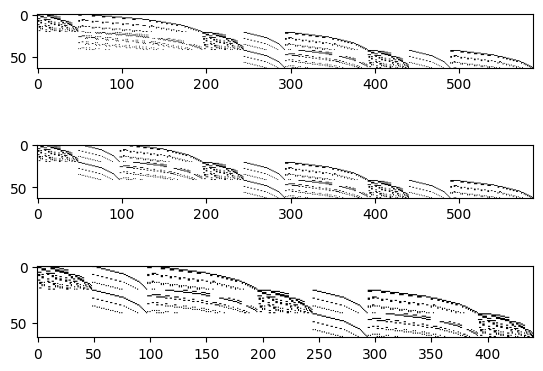

In [15]:
decode_SHYPS(r=3, p=0.001, num_repeat=4, num_shots=20000, max_iter=1000, osd_order=0, window=True, W=3, F=1, plot=True)
plt.show();

[[1 0 1 1 0 0 0]
 [0 1 0 1 1 0 0]
 [0 0 1 0 1 1 0]
 [0 0 0 1 0 1 1]
 [1 0 0 0 1 0 1]
 [1 1 0 0 0 1 0]
 [0 1 1 0 0 0 1]]
[[1 0 1 1 1 0 0]
 [0 1 0 1 1 1 0]
 [0 0 1 0 1 1 1]]
color=0, #edges: 49
color=1, #edges: 49
color=2, #edges: 49
check matrix shape (105, 833), max (row, column) weight (44, 9), min (row, column) weight (28, 2)
detector data shape (20000, 105)
observable data shape (20000, 9)
Stim: noise sampling for 20000 shots, elapsed time: 0.004549851990304887
Elapsed time: 30.676094032940455
Flagged Errors: 0/20000
Logical Errors: 187/20000
Logical error per round: 0.0023457408503354538


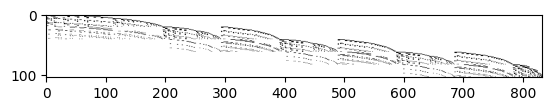

In [16]:
decode_SHYPS(r=3, p=0.001, num_repeat=4, num_shots=20000, max_iter=1000, osd_order=0, window=False, plot=True) # global decoding
plt.show();